In [3]:
import pandas as pd
import numpy as np
import rdkit
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [ ]:
from utils import create_df, compute_fingerprints, compute_descriptors, create_data, eval_metrics

# 1) Data preparation

## О данных:
Выборка примерно сбалансированная:
- 432 vs 361

---
# 2) Model Creation & Learning

In [360]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [102]:
descriptors = [
    "NumHBD",                # Number of Hydrogen Bond Donors (rdMolDescriptors)
    "NumHeavyAtoms",         # Number of Heavy Atoms

    'MolWt',                 # Molecular Weight
    'LogP',                  # LogP (octanol-water partition coefficient)
    'TPSA',                  # Topological Polar Surface Area
    'NumRotatableBonds',     # Number of Rotatable Bonds
    'NumHDonors',            # Number of Hydrogen Bond Donors
    'NumHAcceptors',         # Number of Hydrogen Bond Acceptors
    'FractionCSP3',          # Fraction of sp3 Hybridized Carbons
    'NumAromaticRings',      # Number of Aromatic Rings
    'FractionRotatableBonds',# Fraction of Rotatable Bonds
    'NumHBD',               
    'NumHBA',                # Number of Hydrogen Bond Acceptors (rdMolDescriptors)
    'NumRings',              # Number of Rings
    'NumHeteroatoms',        # Number of Heteroatoms
    'Chi0v',                 # Chi Connectivity Index 0 (Valence)
    'Chi1v',                 # Chi Connectivity Index 1 (Valence)
    'Chi2v',                 # Chi Connectivity Index 2 (Valence)
]

data_path = "./data/small_dataset_solid_liquid.ssv"
columns = ['line_number', 'smiles', 'cas', 'label']

df = create_df(data_path, columns)

In [103]:
X_fps, X_at, y = create_data(
    df,
    descriptors=descriptors,
    apply_norm=False,
    radius=2,
    nbits=4096,
    fingerprints_pca=True,
    pca_dim=32,
)

X_combined = np.hstack([X_fps, X_at])

In [104]:
def fit_and_eval(model, X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    metrics = eval_metrics(y_test, y_pred)

    return metrics

In [105]:
TEST_SIZE = 0.2

## 2.1) RandomForest on X_at

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

fit_and_eval(model, X=X_at, y=y)

{'ACC': 0.9245283018867925,
 'BAL-ACC': 0.9244535951853026,
 'ROC-AUC': 0.9244535951853026,
 'R2': 0.69781438074121}

## 2.2) RandomForest on X_fps with PCA

In [108]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

fit_and_eval(model, X=X_fps, y=y, test_size=TEST_SIZE)

{'ACC': 0.8176100628930818,
 'BAL-ACC': 0.815647766867279,
 'ROC-AUC': 0.815647766867279,
 'R2': 0.2697180867912575}

## 2.3) RandomForst on [X_at, PCA(X_fps)]

In [109]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

fit_and_eval(forest_model, X=X_combined, y=y, test_size=TEST_SIZE)

{'ACC': 0.9182389937106918,
 'BAL-ACC': 0.917960088691796,
 'ROC-AUC': 0.917960088691796,
 'R2': 0.6726322458029775}

---
## 2.4) Catboost on [X_at, PCA(X_fps)]

In [227]:
from catboost import CatBoostClassifier

**Current best**:
```python
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 32,
}

model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 6,
    "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100
}
X = X_combined
```

In [228]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 32,
}

model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 7,
    "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}

In [229]:
X_fps, X_at, y = create_data(df, **data_args)
X_combined = np.hstack([X_fps, X_at])
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=TEST_SIZE, random_state=42)

In [230]:
boosting_model = CatBoostClassifier(**model_args)
boosting_model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred = boosting_model.predict(X_test)

In [231]:
eval_metrics(y_test, y_pred)

{'ACC': 0.9371069182389937,
 'BAL-ACC': 0.9362527716186253,
 'ROC-AUC': 0.9362527716186253,
 'R2': 0.7481786506176751}

---
### 2.5) MLP with [X_at, PCA(X_fps)]

In [232]:
import torch
import torch.nn as nn
import lightning
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

In [233]:
class MLPClassifier(lightning.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, lr=1e-2):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, output_dim)

        self.loss_fn = nn.BCEWithLogitsLoss()

        self.lr = lr

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_out(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, *args, **kwargs):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        return loss

    @torch.no_grad()
    def predict(self, X, threshold=0.5):
        X = torch.tensor(X)
        logits = self(X)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).to(int)

        return preds.flatten().numpy()

    @torch.no_grad()
    def get_embeds(self, x):
        x = F.relu(self.layer_1(x))
        x = self.layer_2(x)

        return x

In [234]:
(torch.tensor([0.4, 0.9]) > 0.5).to(int)

tensor([0, 1])

In [235]:
torch.sigmoid(
    torch.tensor([0.4, 0.9])
)

tensor([0.5987, 0.7109])

In [236]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 8,
}


X_fps, X_at, y = create_data(df, **data_args)
X_combined = np.hstack([X_fps, X_at])

In [237]:
X_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=TEST_SIZE)

In [238]:
train_dataset = TensorDataset(X_train, y_train)

In [239]:
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
lr = 1e-2

mlp_model = MLPClassifier(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, lr=lr
)

In [240]:
max_epochs = 100
batch_size = 1000

train_loader = DataLoader(train_dataset, batch_size=batch_size)
trainer = lightning.Trainer(max_epochs=max_epochs)
trainer.fit(mlp_model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | layer_1   | Linear            | 1.7 K  | train
1 | layer_2   | Linear            | 4.2 K  | train
2 | layer_out | Linear            | 65     | train
3 | loss_fn   | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/Users/aleksandr.varlamov/anaconda3/envs/phase-pred/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to i

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [241]:
y_pred = mlp_model.predict(X_val)

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_20042/3213691226.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


In [242]:
eval_metrics(y_val, y_pred)

{'ACC': 0.8805031446540881,
 'BAL-ACC': 0.8702784891165173,
 'ROC-AUC': 0.8702784891165172,
 'R2': 0.5164852752880922}

---
# predict melting T

- Предсказанное probability для бинарной классификации коррелирует с удалением от разделяющей плоскости: 
  - По факту логиты нейросетки показывают насколько объект удален от разделяющей плоскости
  - Для бустинга это сами вероятности

In [243]:
df_temp = create_df(
    data_path="data/small_dataset_solid_liquid_with_Tmelt_data.ssv",
    columns=['line_number', 'smiles', 'cas', 'label', 'T']
)

In [267]:
df_temp['T'] = df_temp['T'].replace('fail', np.nan).astype(float)

In [268]:
df_temp_available = df_temp[df_temp['T'].notna()]

In [269]:
df_temp_nan = df_temp[df_temp['T'].isna()]

In [270]:
len(df_temp_available) / len(df_temp_nan)

0.3

### Обучу классификатор фазового состояния на тех данных, для которых нет температуры в данных
- На 70% получается
- Чтобы вообще не было никаких data leak'ов так делаю
- Построю зависимость: temp от pred_proba

In [284]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 32,
}

model_args = {
    "iterations": 100,
    "learning_rate": 0.1,
    "depth": 7,
    "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}

In [285]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 32,
}

model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 7,
    "loss_function": 'Logloss',
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}

In [286]:
X_fps_train, X_at_train, y_train = create_data(df_temp_nan, **data_args)
X_combined_train = np.hstack([X_fps_train, X_at_train])

X_fps_val, X_at_val, y_val = create_data(df_temp_available, **data_args)
X_combined_val = np.hstack([X_fps_val, X_at_val])

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_20042/1613388253.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprints'] = smiles.apply(compute_fingerprints, args=(radius, nbits,))
/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_20042/1613388253.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprints'] = smiles.apply(compute_fingerprints, args=(radius, nbits,))


In [287]:
boosting_model = CatBoostClassifier(**model_args)
boosting_model.fit(X_combined_train, y_train, eval_set=(X_test, y_test))

In [288]:
y_pred = boosting_model.predict(X_combined_val)
eval_metrics(y_val, y_pred)

{'ACC': 0.8306010928961749,
 'BAL-ACC': 0.8529285099052542,
 'ROC-AUC': 0.852928509905254,
 'R2': 0.1856158484065462}

In [308]:
pred_probs = boosting_model.predict_proba(X_combined_val)[:, 0]

Text(0, 0.5, 'Melt Temperature')

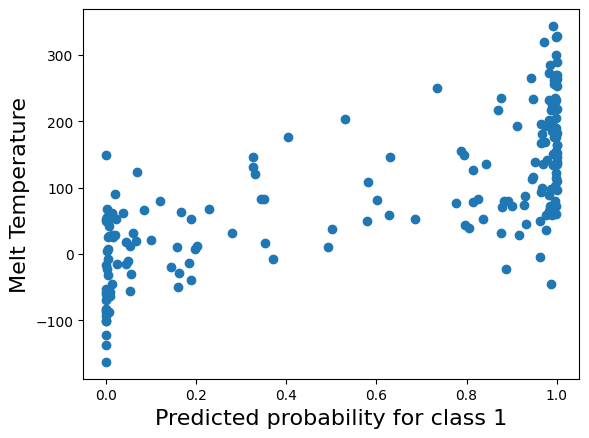

In [314]:
plt.scatter(
    pred_probs, df_temp_available["T"]
)

plt.xlabel("Predicted probability for class 1", fontsize=16)

plt.ylabel("Melt Temperature", fontsize=16)

---

## Предсказание температуры:

In [405]:
from sklearn.linear_model import LinearRegression

In [406]:
from catboost import CatBoostRegressor

In [429]:
TEST_SIZE = 0.4

In [430]:
X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(pred_probs.reshape(-1, 1), df_temp_available["T"], test_size=TEST_SIZE)

In [431]:
model_args = {
    "iterations": 1000,
    "learning_rate": 0.1,
    "depth": 7,
    "verbose": 0,
    "random_seed": 100,
    "l2_leaf_reg": 1
}

In [432]:
boosting_temp = CatBoostRegressor(**model_args)

boosting_temp.fit(X_temp_train, y_temp_train)

In [433]:
y_pred = boosting_temp.predict(X_temp_val)

In [434]:
eval_metrics(y_temp_val, y_pred, type="regr")

{'MSE': 8592.13534098241,
 'RMSE': 92.69377185648672,
 'MAE': 75.30773755091396,
 'R2': 0.00246553724030929}

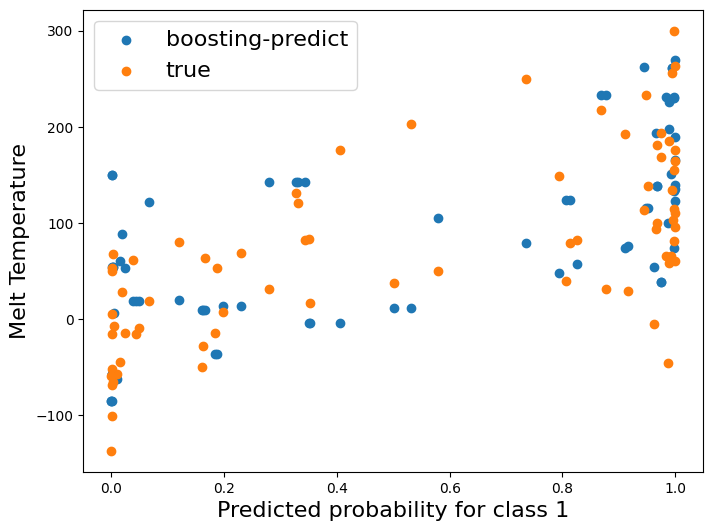

In [435]:
plt.figure(figsize=(8, 6))

plt.scatter(
    X_temp_val, y_pred, label="boosting-predict"
)

plt.scatter(
    X_temp_val, y_temp_val, label="true"
)

plt.xlabel("Predicted probability for class 1", fontsize=16)
plt.ylabel("Melt Temperature", fontsize=16)

plt.legend(fontsize=16)

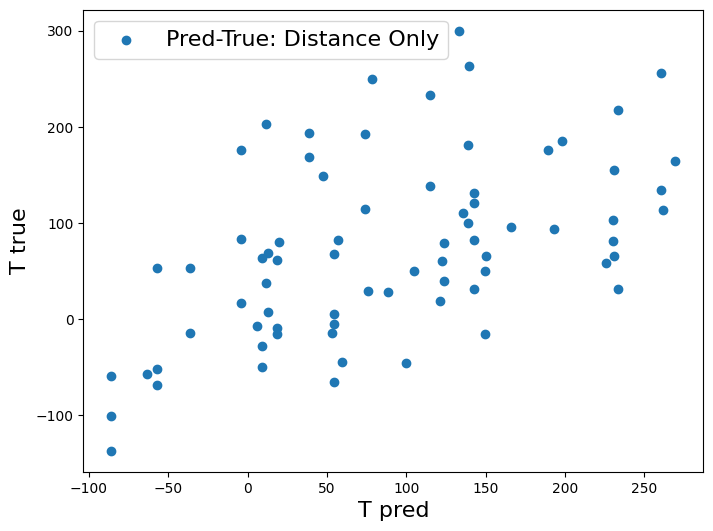

In [436]:
plt.figure(figsize=(8, 6))

plt.scatter(
    y_pred, y_temp_val, label="Pred-True: Distance Only"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

---
### Сравнимся с молекулярными дескрипторами для предсказания T_melt

In [437]:
data_args = {
    "descriptors": descriptors,
    "apply_norm": False,
    "radius": 2,
    "nbits": 4096,
    "fingerprints_pca": True,
    "pca_dim": 4,
}

In [438]:
temp = df_temp_available["T"]
X_fps, X_at, labels = create_data(df_temp_available, **data_args)
X_combined = np.hstack([X_fps, X_at])

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_20042/1613388253.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprints'] = smiles.apply(compute_fingerprints, args=(radius, nbits,))


In [439]:
X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(X_combined, temp, test_size=TEST_SIZE)

In [440]:
model = CatBoostRegressor(**model_args)

In [441]:
model.fit(X_temp_train, y_temp_train)

In [442]:
t_pred = model.predict(X_temp_val)

In [443]:
eval_metrics(y_temp_val, t_pred, type="regr")

{'MSE': 2849.1480112100357,
 'RMSE': 53.37741105758161,
 'MAE': 41.672557394562254,
 'R2': 0.7061501752312204}

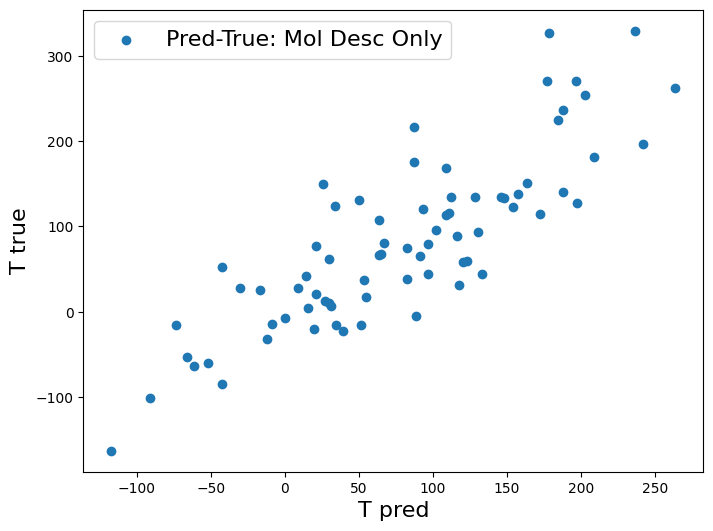

In [444]:
plt.figure(figsize=(8, 6))

plt.scatter(
    t_pred, y_temp_val, label="Pred-True: Mol Desc Only"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)

---
### Комбинация фичей из rdkit и расстояния:

In [445]:
temp = df_temp_available["T"]
X_fps, X_at, labels = create_data(df_temp_available, **data_args)
X_combined = np.hstack([X_fps, X_at, pred_probs.reshape(-1, 1)])

/var/folders/1r/q2t9qwhn5p52b7p0bhtkg3pc0000gq/T/ipykernel_20042/1613388253.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprints'] = smiles.apply(compute_fingerprints, args=(radius, nbits,))


In [446]:
X_temp_train, X_temp_val, y_temp_train, y_temp_val = train_test_split(X_combined, temp, test_size=TEST_SIZE)

In [447]:
model = CatBoostRegressor(**model_args)

In [448]:
model.fit(X_temp_train, y_temp_train)

In [449]:
t_pred = model.predict(X_temp_val)

In [450]:
eval_metrics(y_temp_val, t_pred, type="regr")

{'MSE': 4094.194292973784,
 'RMSE': 63.9858913587502,
 'MAE': 50.69574410505779,
 'R2': 0.6299676129791372}

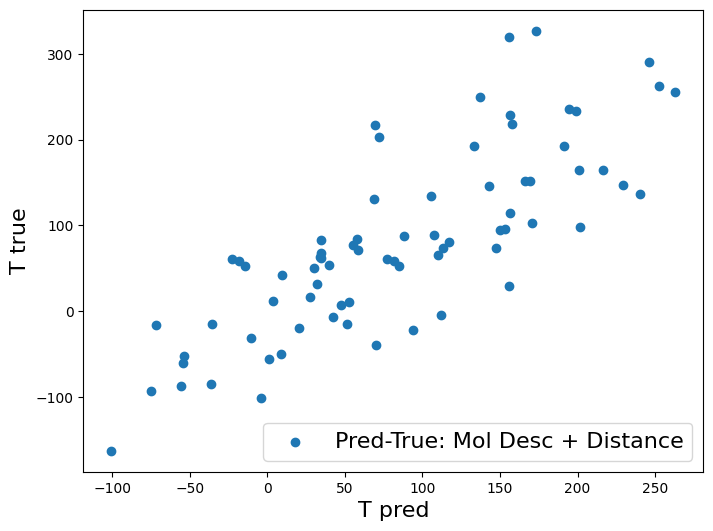

In [451]:
plt.figure(figsize=(8, 6))

plt.scatter(
    t_pred, y_temp_val, label="Pred-True: Mol Desc + Distance"
)

plt.xlabel("T pred", fontsize=16)
plt.ylabel("T true", fontsize=16)

plt.legend(fontsize=16)